In [5]:
# Libs
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load data
torch.manual_seed(42)
train_transform = transforms.Compose([
    transforms.RandomCrop(224, padding=32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    #transforms.RandomErasing(0.8,(0.2,0.3)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
train_ds = datasets.ImageFolder('mydata/train',
                                transform = train_transform,)
test_ds = datasets.ImageFolder('mydata/test',
                                transform = test_transform,)
batch_size=64
def get_dataloader_workers():
    return 4
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=get_dataloader_workers())
test_dl = DataLoader(test_ds,batch_size=batch_size,num_workers=get_dataloader_workers())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3)


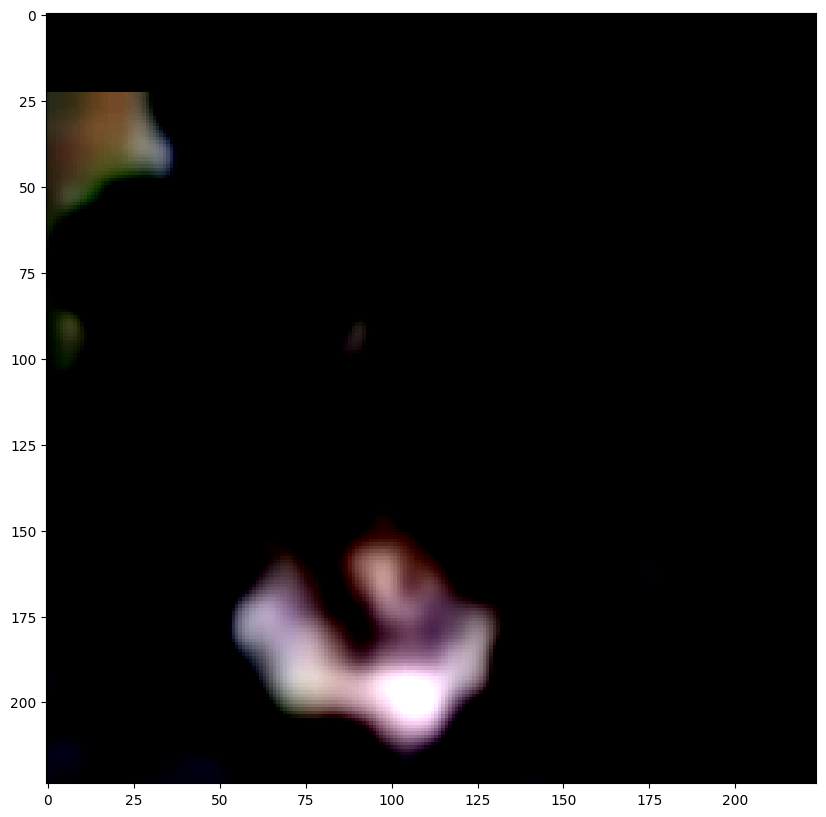

In [7]:
def displayImg(img):
    npImg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npImg,(1,2,0)))
    plt.show()

someImages = 0
someLabels = 0
i=0
for X,y in train_dl:
    someImages=X
    someLabels=y
    break

for i in range(10,11):
    print(someLabels[i])
    displayImg(someImages[i])

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
model=resnet18(num_classes = 10).to(device)
model.train()

Using cuda device


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer.load_state_dict(torch.load('optim_data.pkl'))
scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=200,eta_min=0.001,last_epoch=-1)

In [10]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    train_accuracy =0
    model.train()
    for X,y in tqdm(dataloader):
        X,y = X.to(device), y.to(device)
        # compute prediction
        predict = model(X)
        # compute loss
        loss = loss_fn(predict,y)
        optimizer.zero_grad()
        # backpropagation
        loss.backward()
        optimizer.step()
        # record loss
        train_loss += loss.item()
        train_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
        
    return train_loss,train_accuracy/size

def test(dataloader,model,loss_fn):
    size = len(dataloader.dataset)
    test_loss = 0
    test_accuracy = 0
    model.eval()
    with torch.no_grad():
        for X,y in tqdm(dataloader):
            X = X.to(device)
            y = y.to(device)
            predict = model(X)
            loss = loss_fn(predict,y)
            test_loss += loss.item()
            test_accuracy += (predict.argmax(1) == y).type(torch.float).sum().item()
            
    return test_loss,test_accuracy/size

In [11]:
# Begin training
#model.load_state_dict(torch.load('best.pkl'))
print('The training model is: ',model)
epochs = 100
for i in range(epochs):
    print('Epoch,',i)
    train_loss,train_accuracy = train(train_dl,model,loss_fn,optimizer)
    test_loss,test_accuracy = test(test_dl,model,loss_fn)
    print("train_loss:",train_loss,"  train_accuracy:",train_accuracy*100)
    print("test_loss:",test_loss,"  test_accuracy:",test_accuracy*100)
    scheduler.step()

The training model is:  ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

100%|██████████| 157/157 [00:09<00:00, 17.23it/s]


train_loss: 1383.3091570138931   train_accuracy: 33.78
test_loss: 272.4716915488243   test_accuracy: 39.23
Epoch, 1


100%|██████████| 157/157 [00:09<00:00, 17.22it/s]


train_loss: 1033.0364110469818   train_accuracy: 51.522
test_loss: 443.1750058308244   test_accuracy: 31.64
Epoch, 2


100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


train_loss: 865.9497725963593   train_accuracy: 59.977999999999994
test_loss: 258.3240522891283   test_accuracy: 49.11
Epoch, 3


100%|██████████| 157/157 [00:09<00:00, 16.99it/s]


train_loss: 761.0480418205261   train_accuracy: 64.992
test_loss: 307.07970827817917   test_accuracy: 49.51
Epoch, 4


100%|██████████| 157/157 [00:09<00:00, 16.69it/s]


train_loss: 683.8581466674805   train_accuracy: 68.91000000000001
test_loss: 261.72138026356697   test_accuracy: 51.21
Epoch, 5


100%|██████████| 157/157 [00:09<00:00, 17.14it/s]


train_loss: 617.330271333456   train_accuracy: 71.958
test_loss: 300.398598132655   test_accuracy: 55.98
Epoch, 6


100%|██████████| 157/157 [00:08<00:00, 17.57it/s]


train_loss: 571.8631243109703   train_accuracy: 74.092
test_loss: 164.7231260240078   test_accuracy: 63.31
Epoch, 7


100%|██████████| 157/157 [00:08<00:00, 17.59it/s]


train_loss: 527.0168989598751   train_accuracy: 75.90599999999999
test_loss: 173.15070717781782   test_accuracy: 66.34
Epoch, 8


100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


train_loss: 493.2034091055393   train_accuracy: 77.712
test_loss: 229.34354782104492   test_accuracy: 59.330000000000005
Epoch, 9


100%|██████████| 157/157 [00:08<00:00, 17.48it/s]


train_loss: 462.2327127754688   train_accuracy: 79.32000000000001
test_loss: 352.33564265072346   test_accuracy: 50.23
Epoch, 10


100%|██████████| 157/157 [00:08<00:00, 17.47it/s]


train_loss: 432.70732325315475   train_accuracy: 80.598
test_loss: 108.91802049055696   test_accuracy: 77.45
Epoch, 11


100%|██████████| 157/157 [00:09<00:00, 17.28it/s]


train_loss: 411.47275714576244   train_accuracy: 81.696
test_loss: 133.96125303208828   test_accuracy: 73.0
Epoch, 12


100%|██████████| 157/157 [00:09<00:00, 17.37it/s]


train_loss: 388.32130371034145   train_accuracy: 82.672
test_loss: 342.5780171859078   test_accuracy: 55.269999999999996
Epoch, 13


100%|██████████| 157/157 [00:09<00:00, 17.35it/s]


train_loss: 369.9816164076328   train_accuracy: 83.434
test_loss: 126.27611418813467   test_accuracy: 75.77000000000001
Epoch, 14


100%|██████████| 157/157 [00:09<00:00, 17.36it/s]


train_loss: 350.7781425267458   train_accuracy: 84.206
test_loss: 100.13388593494892   test_accuracy: 79.31
Epoch, 15


100%|██████████| 157/157 [00:08<00:00, 17.47it/s]


train_loss: 335.43372778594494   train_accuracy: 84.946
test_loss: 102.57966974377632   test_accuracy: 79.39
Epoch, 16


100%|██████████| 157/157 [00:09<00:00, 17.24it/s]


train_loss: 315.6433642655611   train_accuracy: 85.816
test_loss: 433.8993764867191   test_accuracy: 54.06999999999999
Epoch, 17


100%|██████████| 157/157 [00:09<00:00, 17.30it/s]


train_loss: 301.3784053325653   train_accuracy: 86.518
test_loss: 143.19000073336065   test_accuracy: 74.07000000000001
Epoch, 18


100%|██████████| 157/157 [00:09<00:00, 17.24it/s]


train_loss: 291.146266028285   train_accuracy: 86.83999999999999
test_loss: 109.51305972598493   test_accuracy: 77.84
Epoch, 19


100%|██████████| 157/157 [00:08<00:00, 17.55it/s]


train_loss: 275.0180593430996   train_accuracy: 87.626
test_loss: 78.89229133725166   test_accuracy: 83.95
Epoch, 20


100%|██████████| 157/157 [00:08<00:00, 17.53it/s]


train_loss: 264.5761777088046   train_accuracy: 88.24
test_loss: 88.34430699050426   test_accuracy: 82.14
Epoch, 21


100%|██████████| 157/157 [00:08<00:00, 17.57it/s]


train_loss: 255.00319906324148   train_accuracy: 88.63600000000001
test_loss: 80.40354440361261   test_accuracy: 83.91
Epoch, 22


100%|██████████| 157/157 [00:08<00:00, 17.51it/s]


train_loss: 243.1248997449875   train_accuracy: 89.11200000000001
test_loss: 98.53341811848804   test_accuracy: 81.52000000000001
Epoch, 23


100%|██████████| 157/157 [00:08<00:00, 17.52it/s]


train_loss: 234.0565308406949   train_accuracy: 89.576
test_loss: 96.82090399321169   test_accuracy: 81.2
Epoch, 24


100%|██████████| 157/157 [00:08<00:00, 17.46it/s]


train_loss: 224.6971877887845   train_accuracy: 89.832
test_loss: 86.11905657500029   test_accuracy: 83.34
Epoch, 25


100%|██████████| 157/157 [00:09<00:00, 17.34it/s]


train_loss: 214.31702569127083   train_accuracy: 90.282
test_loss: 118.06018018448958   test_accuracy: 78.4
Epoch, 26


100%|██████████| 157/157 [00:09<00:00, 17.10it/s]


train_loss: 207.56755969673395   train_accuracy: 90.61399999999999
test_loss: 67.36238158424385   test_accuracy: 86.32
Epoch, 27


100%|██████████| 157/157 [00:09<00:00, 16.50it/s]


train_loss: 195.41738492250443   train_accuracy: 91.266
test_loss: 85.94106723368168   test_accuracy: 83.56
Epoch, 28


100%|██████████| 157/157 [00:09<00:00, 17.43it/s]


train_loss: 190.9669120721519   train_accuracy: 91.53
test_loss: 86.28383339568973   test_accuracy: 83.57
Epoch, 29


100%|██████████| 157/157 [00:09<00:00, 16.77it/s]


train_loss: 181.60033679008484   train_accuracy: 91.782
test_loss: 75.26039589382708   test_accuracy: 85.25
Epoch, 30


100%|██████████| 157/157 [00:09<00:00, 16.84it/s]


train_loss: 174.28746192902327   train_accuracy: 92.154
test_loss: 100.4512171279639   test_accuracy: 82.61
Epoch, 31


100%|██████████| 157/157 [00:09<00:00, 16.66it/s]


train_loss: 167.22506324201822   train_accuracy: 92.514
test_loss: 213.7771348213064   test_accuracy: 70.22
Epoch, 32


100%|██████████| 157/157 [00:08<00:00, 17.55it/s]


train_loss: 163.9536081701517   train_accuracy: 92.54599999999999
test_loss: 101.63465193659067   test_accuracy: 81.27
Epoch, 33


100%|██████████| 157/157 [00:09<00:00, 16.95it/s]


train_loss: 157.752185896039   train_accuracy: 92.944
test_loss: 83.6739814504981   test_accuracy: 84.76
Epoch, 34


100%|██████████| 157/157 [00:08<00:00, 17.50it/s]


train_loss: 151.4682955443859   train_accuracy: 93.21199999999999
test_loss: 63.62845267448574   test_accuracy: 87.88
Epoch, 35


100%|██████████| 157/157 [00:09<00:00, 17.35it/s]


train_loss: 142.92791531048715   train_accuracy: 93.518
test_loss: 66.88487950712442   test_accuracy: 87.53999999999999
Epoch, 36


100%|██████████| 157/157 [00:09<00:00, 17.20it/s]


train_loss: 137.72757484391332   train_accuracy: 93.716
test_loss: 114.16447663679719   test_accuracy: 81.01
Epoch, 37


100%|██████████| 157/157 [00:08<00:00, 17.45it/s]


train_loss: 135.18000735715032   train_accuracy: 93.81
test_loss: 61.62083000410348   test_accuracy: 88.6
Epoch, 38


100%|██████████| 157/157 [00:09<00:00, 17.36it/s]


train_loss: 128.75075542926788   train_accuracy: 94.25
test_loss: 379.3170039495453   test_accuracy: 63.67
Epoch, 39


100%|██████████| 157/157 [00:08<00:00, 17.49it/s]


train_loss: 121.75953853689134   train_accuracy: 94.426
test_loss: 70.80912976898253   test_accuracy: 87.57000000000001
Epoch, 40


100%|██████████| 157/157 [00:09<00:00, 16.95it/s]


train_loss: 119.54479708522558   train_accuracy: 94.56
test_loss: 119.48303147405386   test_accuracy: 81.58
Epoch, 41


100%|██████████| 157/157 [00:08<00:00, 17.64it/s]


train_loss: 114.08259299583733   train_accuracy: 94.808
test_loss: 68.391737151891   test_accuracy: 87.24
Epoch, 42


100%|██████████| 157/157 [00:09<00:00, 17.42it/s]


train_loss: 107.6109451316297   train_accuracy: 95.092
test_loss: 93.72088804654777   test_accuracy: 84.89999999999999
Epoch, 43


100%|██████████| 157/157 [00:08<00:00, 18.64it/s]


train_loss: 106.23001499660313   train_accuracy: 95.178
test_loss: 74.67165251262486   test_accuracy: 87.2
Epoch, 44


100%|██████████| 157/157 [00:08<00:00, 17.86it/s]


train_loss: 101.88848071545362   train_accuracy: 95.384
test_loss: 72.44576467573643   test_accuracy: 87.63
Epoch, 45


100%|██████████| 157/157 [00:08<00:00, 17.45it/s]


train_loss: 97.47274618782103   train_accuracy: 95.628
test_loss: 128.28353533428162   test_accuracy: 81.51
Epoch, 46


100%|██████████| 157/157 [00:08<00:00, 18.18it/s]


train_loss: 99.13742481917143   train_accuracy: 95.43199999999999
test_loss: 68.27450920920819   test_accuracy: 88.64999999999999
Epoch, 47


100%|██████████| 157/157 [00:08<00:00, 17.60it/s]


train_loss: 87.63395509403199   train_accuracy: 96.06400000000001
test_loss: 99.21589909610339   test_accuracy: 84.22
Epoch, 48


100%|██████████| 157/157 [00:08<00:00, 18.07it/s]


train_loss: 90.1603153636679   train_accuracy: 95.858
test_loss: 160.41748393606395   test_accuracy: 80.4
Epoch, 49


100%|██████████| 157/157 [00:09<00:00, 17.25it/s]


train_loss: 85.39684803131968   train_accuracy: 96.1
test_loss: 64.17099815873735   test_accuracy: 89.08
Epoch, 50


100%|██████████| 157/157 [00:08<00:00, 17.96it/s]


train_loss: 78.24265120178461   train_accuracy: 96.406
test_loss: 79.14424591668649   test_accuracy: 87.6
Epoch, 51


100%|██████████| 157/157 [00:09<00:00, 16.99it/s]


train_loss: 78.85473043331876   train_accuracy: 96.406
test_loss: 68.60171896079555   test_accuracy: 89.23
Epoch, 52


100%|██████████| 157/157 [00:08<00:00, 18.31it/s]


train_loss: 72.57760042883456   train_accuracy: 96.696
test_loss: 75.59255419112742   test_accuracy: 88.24
Epoch, 53


100%|██████████| 157/157 [00:08<00:00, 18.10it/s]


train_loss: 74.00114100473002   train_accuracy: 96.684
test_loss: 94.41991931200027   test_accuracy: 85.71
Epoch, 54


100%|██████████| 157/157 [00:08<00:00, 17.50it/s]


train_loss: 71.03921869862825   train_accuracy: 96.756
test_loss: 68.33989036735147   test_accuracy: 88.92999999999999
Epoch, 55


100%|██████████| 157/157 [00:08<00:00, 17.59it/s]


train_loss: 64.3545405943878   train_accuracy: 97.08
test_loss: 62.50183299998753   test_accuracy: 89.77000000000001
Epoch, 56


100%|██████████| 157/157 [00:09<00:00, 17.26it/s]


train_loss: 64.16432841680944   train_accuracy: 97.114
test_loss: 90.9532785564661   test_accuracy: 86.44
Epoch, 57


100%|██████████| 157/157 [00:09<00:00, 17.37it/s]


train_loss: 60.72634195443243   train_accuracy: 97.264
test_loss: 63.1790896197781   test_accuracy: 89.79
Epoch, 58


100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


train_loss: 57.655347308842465   train_accuracy: 97.396
test_loss: 74.67250506021082   test_accuracy: 88.59
Epoch, 59


100%|██████████| 157/157 [00:08<00:00, 17.98it/s]


train_loss: 57.97872858599294   train_accuracy: 97.328
test_loss: 65.89497982803732   test_accuracy: 89.56
Epoch, 60


100%|██████████| 157/157 [00:08<00:00, 17.54it/s]


train_loss: 53.82762965094298   train_accuracy: 97.58
test_loss: 86.10903723351657   test_accuracy: 87.86
Epoch, 61


100%|██████████| 157/157 [00:08<00:00, 17.53it/s]


train_loss: 49.76203958038241   train_accuracy: 97.762
test_loss: 70.20481962524354   test_accuracy: 89.56
Epoch, 62


100%|██████████| 157/157 [00:08<00:00, 17.89it/s]


train_loss: 49.82247616047971   train_accuracy: 97.71
test_loss: 65.8978210715577   test_accuracy: 89.86
Epoch, 63


100%|██████████| 157/157 [00:09<00:00, 17.27it/s]


train_loss: 46.76843553618528   train_accuracy: 97.858
test_loss: 67.29945822060108   test_accuracy: 90.08
Epoch, 64


100%|██████████| 157/157 [00:08<00:00, 17.58it/s]


train_loss: 46.1941228909418   train_accuracy: 97.934
test_loss: 66.51186701614643   test_accuracy: 89.75999999999999
Epoch, 65


100%|██████████| 157/157 [00:08<00:00, 17.75it/s]


train_loss: 46.51793189428281   train_accuracy: 97.858
test_loss: 82.2908473573043   test_accuracy: 88.26
Epoch, 66


100%|██████████| 157/157 [00:09<00:00, 16.37it/s]


train_loss: 42.312127741926815   train_accuracy: 98.06200000000001
test_loss: 66.26340244663879   test_accuracy: 90.42
Epoch, 67


100%|██████████| 157/157 [00:09<00:00, 17.34it/s]


train_loss: 42.96785778319463   train_accuracy: 98.104
test_loss: 82.2505272012204   test_accuracy: 88.72
Epoch, 68


100%|██████████| 157/157 [00:09<00:00, 17.14it/s]


train_loss: 38.10364826070145   train_accuracy: 98.244
test_loss: 195.71474989247508   test_accuracy: 82.33
Epoch, 69


100%|██████████| 157/157 [00:08<00:00, 17.90it/s]


train_loss: 37.75123530928977   train_accuracy: 98.33800000000001
test_loss: 74.28299468000841   test_accuracy: 89.3
Epoch, 70


100%|██████████| 157/157 [00:09<00:00, 17.11it/s]


train_loss: 38.58735347981565   train_accuracy: 98.328
test_loss: 75.67111534066498   test_accuracy: 89.75
Epoch, 71


100%|██████████| 157/157 [00:09<00:00, 17.33it/s]


train_loss: 35.55063762702048   train_accuracy: 98.392
test_loss: 64.48676204308867   test_accuracy: 90.75
Epoch, 72


100%|██████████| 157/157 [00:09<00:00, 17.05it/s]


train_loss: 34.638906689942814   train_accuracy: 98.428
test_loss: 113.34928863332607   test_accuracy: 86.77
Epoch, 73


100%|██████████| 157/157 [00:09<00:00, 16.56it/s]


train_loss: 35.60219756467268   train_accuracy: 98.4
test_loss: 123.76529495461727   test_accuracy: 85.89
Epoch, 74


100%|██████████| 157/157 [00:09<00:00, 16.31it/s]


train_loss: 29.632526144734584   train_accuracy: 98.70400000000001
test_loss: 66.18470676324796   test_accuracy: 91.16
Epoch, 75


100%|██████████| 157/157 [00:08<00:00, 17.47it/s]


train_loss: 29.061653535696678   train_accuracy: 98.71
test_loss: 66.26104859542102   test_accuracy: 91.11
Epoch, 76


100%|██████████| 157/157 [00:09<00:00, 17.37it/s]


train_loss: 29.89499113941565   train_accuracy: 98.66
test_loss: 90.22754677890407   test_accuracy: 88.44999999999999
Epoch, 77


100%|██████████| 157/157 [00:08<00:00, 17.69it/s]


train_loss: 25.61914324236568   train_accuracy: 98.896
test_loss: 66.29628767620306   test_accuracy: 91.03
Epoch, 78


100%|██████████| 157/157 [00:08<00:00, 17.61it/s]


train_loss: 25.241832513595   train_accuracy: 98.856
test_loss: 70.39029487570224   test_accuracy: 90.73
Epoch, 79


100%|██████████| 157/157 [00:09<00:00, 17.15it/s]


train_loss: 22.128158458159305   train_accuracy: 99.036
test_loss: 66.69366800412536   test_accuracy: 90.96
Epoch, 80


100%|██████████| 157/157 [00:08<00:00, 17.65it/s]


train_loss: 24.916943653603084   train_accuracy: 98.898
test_loss: 67.61741984821856   test_accuracy: 91.10000000000001
Epoch, 81


100%|██████████| 157/157 [00:08<00:00, 18.89it/s]


train_loss: 22.78244251117576   train_accuracy: 98.99799999999999
test_loss: 85.36831377074122   test_accuracy: 89.55
Epoch, 82


100%|██████████| 157/157 [00:07<00:00, 19.63it/s]


train_loss: 22.28690591477789   train_accuracy: 98.994
test_loss: 67.53062017261982   test_accuracy: 90.74
Epoch, 83


100%|██████████| 157/157 [00:08<00:00, 19.41it/s]


train_loss: 21.277050397533458   train_accuracy: 99.11
test_loss: 69.40720645990223   test_accuracy: 91.12
Epoch, 84


100%|██████████| 157/157 [00:08<00:00, 17.85it/s]


train_loss: 19.95791423949413   train_accuracy: 99.148
test_loss: 70.0221372009255   test_accuracy: 91.07
Epoch, 85


100%|██████████| 157/157 [00:08<00:00, 17.57it/s]


train_loss: 19.489638047583867   train_accuracy: 99.14
test_loss: 63.789575742557645   test_accuracy: 91.72
Epoch, 86


100%|██████████| 157/157 [00:08<00:00, 17.76it/s]


train_loss: 17.501092973456252   train_accuracy: 99.208
test_loss: 66.31978001818061   test_accuracy: 91.47999999999999
Epoch, 87


100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


train_loss: 16.21877945162123   train_accuracy: 99.312
test_loss: 82.57940830243751   test_accuracy: 89.95
Epoch, 88


100%|██████████| 157/157 [00:08<00:00, 17.66it/s]


train_loss: 18.94474953180179   train_accuracy: 99.194
test_loss: 73.57186982035637   test_accuracy: 90.63
Epoch, 89


100%|██████████| 157/157 [00:08<00:00, 18.11it/s]


train_loss: 17.045674670487642   train_accuracy: 99.292
test_loss: 73.639632506005   test_accuracy: 91.01
Epoch, 90


100%|██████████| 157/157 [00:08<00:00, 17.70it/s]


train_loss: 14.128466468071565   train_accuracy: 99.402
test_loss: 66.83346766357135   test_accuracy: 91.18
Epoch, 91


100%|██████████| 157/157 [00:09<00:00, 17.38it/s]


train_loss: 13.070944172810414   train_accuracy: 99.45
test_loss: 68.47388414666057   test_accuracy: 91.33
Epoch, 92


100%|██████████| 157/157 [00:08<00:00, 18.05it/s]


train_loss: 13.615498621598817   train_accuracy: 99.396
test_loss: 87.63590319233481   test_accuracy: 90.03
Epoch, 93


100%|██████████| 157/157 [00:09<00:00, 17.10it/s]


train_loss: 12.850745275703957   train_accuracy: 99.5
test_loss: 174.63117099716328   test_accuracy: 84.75
Epoch, 94


100%|██████████| 157/157 [00:08<00:00, 17.79it/s]


train_loss: 14.142461264040321   train_accuracy: 99.396
test_loss: 70.18710335437208   test_accuracy: 91.56
Epoch, 95


100%|██████████| 157/157 [00:08<00:00, 17.76it/s]


train_loss: 11.606859973544488   train_accuracy: 99.518
test_loss: 72.42790994094685   test_accuracy: 91.18
Epoch, 96


100%|██████████| 157/157 [00:09<00:00, 17.04it/s]


train_loss: 10.596764640995389   train_accuracy: 99.58399999999999
test_loss: 67.98437375114008   test_accuracy: 91.64999999999999
Epoch, 97


100%|██████████| 157/157 [00:08<00:00, 17.66it/s]


train_loss: 10.985736950678984   train_accuracy: 99.536
test_loss: 70.46942409550684   test_accuracy: 91.63
Epoch, 98


100%|██████████| 157/157 [00:09<00:00, 17.05it/s]


train_loss: 10.732317239468102   train_accuracy: 99.59
test_loss: 127.55714978964534   test_accuracy: 87.22
Epoch, 99


100%|██████████| 157/157 [00:09<00:00, 16.52it/s]

train_loss: 10.72903153070365   train_accuracy: 99.566
test_loss: 98.35815981775522   test_accuracy: 88.7
